Feature extraction consists of represantations learned by previously trained model.

Feature extraction consist of taking convolutional base (convlayers + pooling layers, before flattening) and run new data through it, and training a new classifer on top of the output.

## Why only reuse Convolutional Base?

Reusing DENSELY connected layers SHOULD BE AVOIDED. The reason is representations learnde by convbase are likely to be more generic and more reusable. 

The feature maps of a convnet are presence maps of generic concepts over a picture, which are likely to be useful regardless of the computer vision tasks at hand.

Neverthless, representations learned by classifer will necessarily be specific to the set o classes on which the model was trained. They'll only contain info about the presence probability of this or that class in entire picture

Moreover, Densely Connected layers should not contain info about where objects are located in input image. These layers get rid of notion of space, wherase the object location is still described convolutional feature maps.

In [1]:
from tensorflow import keras
import tensorflow as tf

In [3]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet", # checkpoint from which initalize the model
    include_top = False, # refers to including Densely Connected Classifier on top of network. In this case we have only 2, and model has 1000, so do not use
    input_shape = (180,180,3)
)

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

At this stage we can proceed in 2 ways

Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier similar to those you saw in chapter 4 of this book. Fast but not allows data augmentation.

Or we can extend model by adding Dense Layers on top, and run the whole from end to end on input data. This'll allow data augmentaion, but far more expensive than first one.

## Fast Feature Extraction without Data Augmentation

In [10]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [14]:
import pathlib
org_dir = pathlib.Path("train")
new_dir = pathlib.Path("cats_dogs")
from keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_dir / "train", image_size = (180,180), batch_size = 32
)

validation_set = image_dataset_from_directory(
    new_dir / "validation", image_size = (180,180), batch_size = 32
)

test_set = image_dataset_from_directory(
    new_dir / "test", image_size = (180,180), batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_set)
test_features, test_labels = get_features_and_labels(test_set)

In [16]:
train_features.shape

(2000, 5, 5, 512)

In [17]:
inputs = keras.Input(shape = (5,5,512))
from keras import layers

x = layers.Flatten() (inputs)
x = layers.Dense(256) (x)
x = layers.Dropout(.5) (x)

outputs = layers.Dense(1, activation ="sigmoid")(x)
model = keras.Model(inputs,outputs)

In [19]:
model.compile(loss = "binary_crossentropy", optimizer="rmsprop", metrics = ["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss",
    )
]

In [20]:
history = model.fit(
    train_features, train_labels, epochs = 20, validation_data = (val_features, val_labels), callbacks = callbacks
)

Epoch 1/20
63/63 [==============================] - 2s 24ms/step - loss: 17.9977 - accuracy: 0.9175 - val_loss: 5.2326 - val_accuracy: 0.9600
Epoch 2/20
63/63 [==============================] - 1s 20ms/step - loss: 3.5869 - accuracy: 0.9745 - val_loss: 13.4674 - val_accuracy: 0.9390
Epoch 3/20
63/63 [==============================] - 1s 20ms/step - loss: 2.2646 - accuracy: 0.9855 - val_loss: 5.5882 - val_accuracy: 0.9720
Epoch 4/20
63/63 [==============================] - 1s 20ms/step - loss: 1.0256 - accuracy: 0.9890 - val_loss: 5.5708 - val_accuracy: 0.9690
Epoch 5/20
63/63 [==============================] - 1s 20ms/step - loss: 1.4701 - accuracy: 0.9920 - val_loss: 9.5824 - val_accuracy: 0.9650
Epoch 6/20
63/63 [==============================] - 1s 21ms/step - loss: 1.3493 - accuracy: 0.9920 - val_loss: 5.6161 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 1s 21ms/step - loss: 1.2512 - accuracy: 0.9930 - val_loss: 6.1698 - val_accuracy: 0.9750
Epoch 8/20


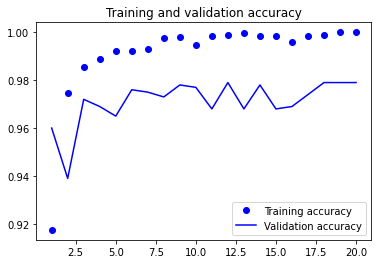

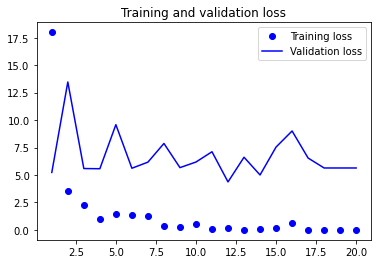

In [22]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()